In [2]:
import numpy as np
import pyemma
import matplotlib
import matplotlib.pyplot as plt
import pyemma.plots as mplt
import h5py
import MSMRD.trajectories.trajectoryTools as trajectoryTools
from MSMRD.discretization import partitionSphere, plotPartitionedSphere
%load_ext Cython

In [13]:
%matplotlib inline
#%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (4.0, 4.0)
plt.rc('text', usetex='True')
plt.rc('font', family='serif')

141


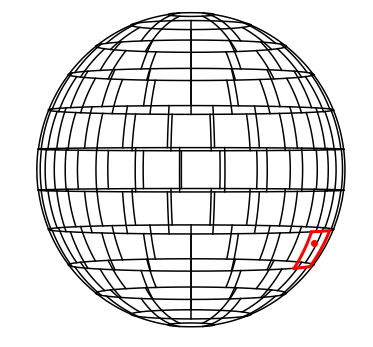

In [14]:
# Testing correct state output mini script (use along with testSpherePrtitionPlot NB)
# Consistent with test
numPartitions = 177
boxSize = 5
minima = np.array([[-0.9,0.7,0.3] , [-0.1,0.9,0.7],  [0.8,0.8,-0.8],  \
                  [-1.0,-0.3,-0.4], [0.0,0.0,0.0],   [0.9,-0.1,-0.9], \
                  [-0.7,-1.0,-0.3], [0.0,-0.9,0.1],  [0.8,-0.2,0.8]])
regionsPerCollar, phis, thetas = partitionSphere(numPartitions)
discretizer = trajectoryTools.trajDiscretization3DCython(minima, boxSize)
discretizer.getSpherePartition(regionsPerCollar, phis, thetas)
coord = np.array([3.4,-2,-2]) # norm larger than innerMSMrad (boxSize/2)
sphereState = discretizer.getStatePy(coord,-1) - (len(minima) - 1)

# Call function to plot state and coordinate in spherical partition
print sphereState
plotPartitionedSphere(numPartitions = numPartitions, plotState=sphereState, coord=coord)

In [5]:
%%time
numfiles = 1 #200
# Load partitions, boxsize and minimas
numPartitions = 322
boxSize = 5
regionsPerCollar, phis, thetas = partitionSphere(numPartitions)
minima = np.array([[-0.9,0.7,0.3] , [-0.1,0.9,0.7],  [0.8,0.8,-0.8],  \
                  [-1.0,-0.3,-0.4], [0.0,0.0,0.0],   [0.9,-0.1,-0.9], \
                  [-0.7,-1.0,-0.3], [0.0,-0.9,0.1],  [0.8,-0.2,0.8]])

# Extract trajectories from file using asym2Dtraj class
fname = '../data/asym3D/3DasymTrajs_pBox5_sf2_R4_RT1e7_dt001_si10_'
dimension = 3
discretizer = trajectoryTools.trajDiscretization3DCython(minima, boxSize)
discretizer.getSpherePartition(regionsPerCollar, phis, thetas)
dTrajs = []
#fullDTrajs = []
truncTrajs = []
dTruncTrajs = []
i = 0
samplingInterval = 10 # in the original computation
for number in range(numfiles):
    f = h5py.File(fname + str(number) + '.h5', 'r')
    data = np.array(f['traj'], dtype=float)
    f.close()
    if not np.allclose(data[1:,0]-data[:-1,0], samplingInterval):
        print 'timestep not constant'
    traj = data[:,1:dimension+1]
    #fullDTrajs.append(discretizer.getdTrajs([traj]))
    dTrajs += discretizer.getdTrajs([traj])
    lastTruncTrajs = discretizer.getTruncatedTraj(traj, prepend=True)
    truncTrajs += lastTruncTrajs
    dTruncTrajs += discretizer.getdTrajs(lastTruncTrajs)
    i+=1
    if i % 10 == 0:
        print str(i/float(numfiles) * 100)+'% done'
    # delete memory to avoid overhead
    del data
    del traj

CPU times: user 24.6 s, sys: 52 ms, total: 24.6 s
Wall time: 24.6 s


In [6]:
its = pyemma.msm.its(dTrajs, lags = 20)

In [7]:
# Plot implied time scales
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2, dt=1)
plt.ylabel(r"timescale/steps", fontsize = 24)
plt.xlabel(r"lag time/steps", fontsize = 24)
#plt.xlim(0,900)
#plt.ylim(-100,1700)
#plt.xlim(0,100)
#plt.ylim(100,10000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([ -20.,    0.,   20.,   40.,   60.,   80.,  100.]),
 <a list of 7 Text yticklabel objects>)

In [8]:
# Get exit/entry lookup tables
#%%time
entryTrajsStart, entryTrajsEnd, entryTimes = discretizer.getLookupTableEntry(dTruncTrajs, truncTrajs)
exitPositions, exitTimes = discretizer.getLookupTableExit(dTruncTrajs, truncTrajs)

[ 11  12  15  17  17  17  18  18  19  20  22  22  24  25  25  25  26  27
  27  28  29  29  29  30  31  31  31  32  33  33  33  34  34  34  37  37
  37  38  38  40  41  41  42  42  42  42  42  44  46  47  47  47  47  50
  50  50  52  53  54  55  57  58  59  60  60  61  61  61  62  63  64  64
  65  66  66  68  68  69  69  70  70  70  71  71  71  73  74  75  77  80
  85  86  88  89  92  92  93  93  95  95  95  96  99 103 103 104 109 110
 110 112 112 113 114 116 117 118 121 128 128 130 137 137 142 145 153 170
 174 179 182 183 191 203 204 219 220 246 440]
[  7  10  11  14  15  19  19  20  20  20  21  21  23  24  26  27  27  27
  27  28  28  29  30  30  31  31  32  33  33  34  36  37  37  38  38  38
  39  39  41  41  41  41  42  42  42  43  44  45  45  45  46  46  49  49
  50  51  51  52  54  54  55  55  58  58  59  60  62  62  63  63  63  64
  64  65  67  67  69  69  69  69  69  70  70  72  72  73  73  73  75  78
  78  79  79  80  80  81  81  82  83  83  83  85  87  87  88  88  90  91
  92 

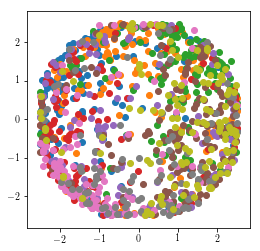

In [15]:
for i in range(9):
    plt.scatter(np.array(exitPositions[i])[:,0], np.array(exitPositions[i])[:,1])
for i in range(9):
    print np.sort(exitTimes[i])

In [89]:
# Partition MSM entry trajectories into states in the sphere 
spherePartitionsForLookUp = 150
regionsPerCollar2, phis2, thetas2 = partitionSphere(spherePartitionsForLookUp)
thetas_coord = np.arctan2(entryTrajsStart[:,1], entryTrajsStart[:,0])
thetas_coord[thetas_coord<0] = thetas_coord[thetas_coord<0] + 2*np.pi
r = np.linalg.norm(entryTrajsStart[:], axis=1)
phis_coords = np.arccos(entryTrajsStart[:,2]/r)
sortedEntryTrajsStart = []
sortedEntryTrajsEnd = []
sortedEntryTimes = []
for i in range(len(regionsPerCollar2)):
    phiIncrement = np.pi/len(regionsPerCollar2)
    idcs_phi = np.where(np.logical_and(phis_coords>i*phiIncrement, phis_coords<= (i+1)*phiIncrement))[0]
    for j in range(regionsPerCollar2[i]):
        thetaIncrement = 2*np.pi/regionsPerCollar2[i]
        idcs_theta = np.where(np.logical_and(thetas_coord>j*thetaIncrement, thetas_coord<= (j+1)*thetaIncrement))[0]
        idcs = np.intersect1d(idcs_phi,idcs_theta)
        sortedEntryTrajsStart.append(entryTrajsStart[idcs])
        sortedEntryTimes.append(entryTimes[idcs])
        sortedEnds = []
        for j in idcs:
            sortedEnds.append(entryTrajsEnd[j])
        sortedEntryTrajsEnd.append(sortedEnds)
        

array([[  1.65285707e-01,  -3.07257295e-01,  -2.06347823e+00],
       [  4.98673946e-01,   7.73191825e-02,  -2.40250015e+00],
       [ -5.93381166e-01,  -1.59266755e-01,  -2.31191373e+00],
       [  1.61793023e-01,   5.85813880e-01,  -2.35794163e+00],
       [  3.36184084e-01,   4.67187107e-01,  -2.31080961e+00],
       [  3.46393019e-01,   1.55821964e-01,  -2.31598973e+00],
       [  4.02434841e-02,  -4.17416483e-01,  -2.36413240e+00],
       [ -1.85045630e-01,   2.26765424e-01,  -2.44935846e+00],
       [  1.04365610e-02,  -4.10644799e-01,  -2.33084774e+00],
       [ -3.52694769e-03,  -1.81332827e-01,  -2.34527040e+00],
       [  1.85669795e-01,   1.53935134e-01,  -2.36755681e+00],
       [  2.48308748e-01,  -3.52591187e-01,  -2.39778757e+00],
       [  1.27920657e-01,   1.40484959e-01,  -2.47853971e+00],
       [ -5.39067090e-02,   3.81071091e-01,  -2.41106582e+00],
       [  3.67688566e-01,  -2.23748699e-01,  -2.35842681e+00],
       [  4.89677489e-01,   7.46060014e-02,  -2.3275451

In [ ]:
# Need to refactor code to use sphere partitions instead of 2D angular ones
angles = np.arctan2(entryTrajsStart[:,1], entryTrajsStart[:,0]) + np.pi
NangularPartitions = 60
angularMap = []
sortedEntryTrajsStart = []
sortedEntryTrajsEnd = []
sortedEntryTimes = []
for i in range(NangularPartitions):
    angularIncrement = 2*np.pi/NangularPartitions
    idcs = np.where(np.logical_and(angles>i*angularIncrement, angles<= (i+1)*angularIncrement))[0]
    sortedEntryTrajsStart.append(entryTrajsStart[idcs])
    sortedEntryTimes.append(entryTimes[idcs])
    sortedEnds = []
    for j in idcs:
        sortedEnds.append(entryTrajsEnd[j])
    sortedEntryTrajsEnd.append(sortedEnds)